# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
# Import
import os
import cv2

import numpy as np
import PIL
import torch
import torchvision

from torchvision import datasets
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

In [2]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_scratch = {'train': None, 'valid': None, 'test': None}

In [3]:
# Indicate train and test data location
train_data_path = "/data/landmark_images/train"
test_data_path = "/data/landmark_images/test"

# Set hyper parameters
batch_size = 32
num_workers = 0
valid_size = 0.2
image_size = 224

# Data
train_transform = transforms.Compose([
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(train_data_path, transform=train_transform)
test_data = datasets.ImageFolder(test_data_path, transform=valid_transform)

# Split train and valid sets
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for training and validation batches
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)

# Assign data loaders for training, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler,
                                          batch_size=batch_size, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, sampler=valid_sampler,
                                          batch_size=batch_size, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size, num_workers=num_workers)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

In [4]:
classes = os.listdir("/data/landmark_images/train")

classes = sorted(classes)

print(len(classes))

50


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
- I used PyTorch class torchvision.transforms.RandomResizedCrop for resizing the image. It crops a random portion of image and resizes it to a given size. In this case size 224 is picked as I saw the template the golden gate bridge gaved. The result input tensor size is (3,224,224). Also it is the size of images from ImageNet.
- For the sake of more accurate train and test outcome I decided to do image augmentation. The methods I used are RandomHorizontalFlip for train and CenterCrop for valid. 

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

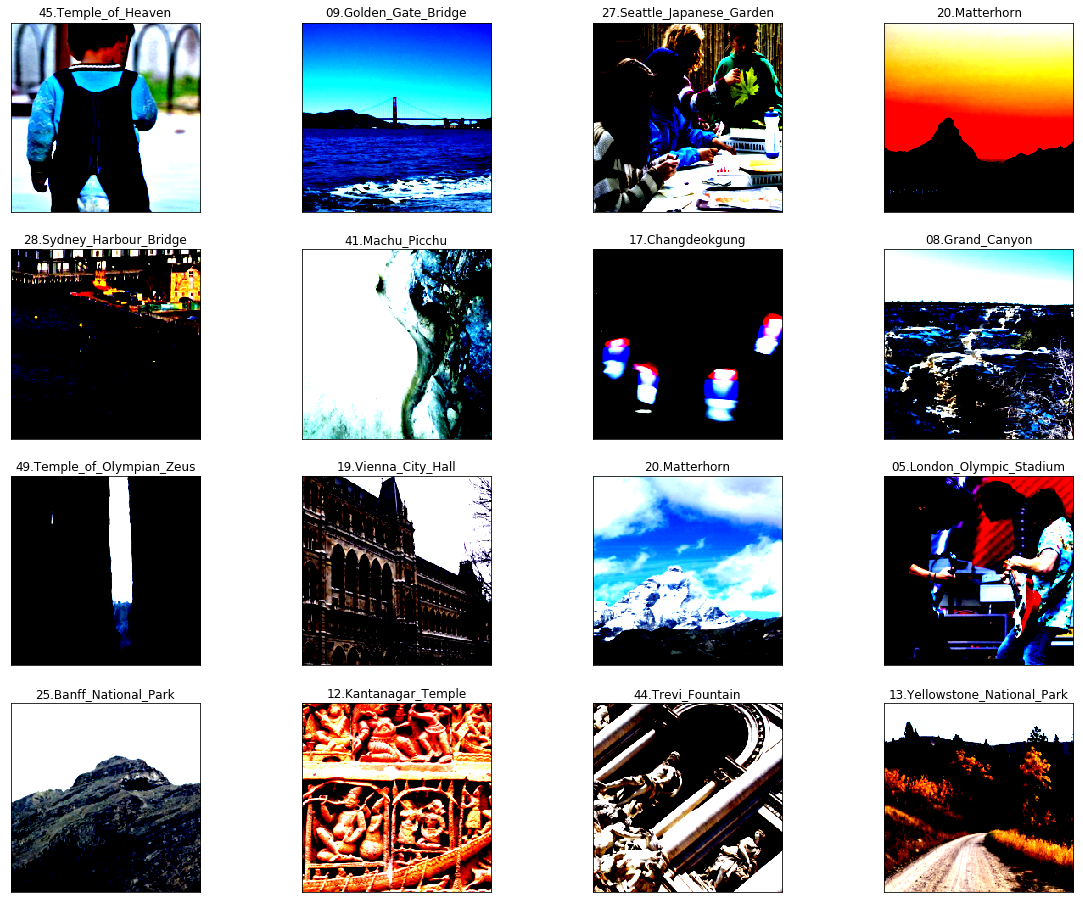

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

dataiter = iter(train_loader)   
images, labels = dataiter.next()
images = images.numpy() #Convert images to numpy from Tensor 

fig = plt.figure(figsize=(20, 16))
for i in np.arange(16):
    axis = fig.add_subplot(4, 16/4,i+1,xticks=[],yticks=[])
    plt.imshow(np.transpose(images[i], (1,2,0)).clip(0,1))
    axis.set_title(classes[labels[i]])

### Initialize use_cuda variable

In [6]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [7]:
import torch.optim as optim

## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    return optimizer

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [8]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # sees 224x224x3
        self.bn1 = nn.BatchNorm2d(32)
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        
        # sees 112x112x32
        self.bn2 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    
        # sees 56x56x64
        self.bn3 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
  
        # sees 28x28x128
        self.bn4 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        
        # sees 14x14x256
        self.fc1 = nn.Linear(14*14*256, 512)
        
        self.bn5 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 50)
        
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        x = x.reshape(-1, 14*14*256)
        x = self.dropout(x)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [9]:
print(model_scratch)

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (bn5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=50, bias=True)
  (dropout): Dropout(p=0.25

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  
- I built a CNN classifier following on the rule of thumb – the convolutional layers with number of features increased in higher layers, and a common kernel size (3, 3) with padding=1. ReLu activation function is also commonly used. After that are the fully connected (flattened) layer and output layer to classify 50 targets. The batch normalization and dropout techniques are implemented as well for overfitting.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [10]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            pred = model(data)
            loss = criterion(pred, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path

        if valid_loss <= valid_loss_min:
            print("Validation loss decreased: {:.6f} ---> {:.6f}. Saving model !".format(
                  valid_loss_min, valid_loss))
            torch.save(model.state_dict(), "model_scratch.pt")
            valid_loss_min = valid_loss        

    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [30]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 0.02)
        m.bias.data.fill_(0)
        
#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.893128 	Validation Loss: 3.772501
Validation loss decreased: inf ---> 3.772501. Saving model !
Epoch: 2 	Training Loss: 3.668114 	Validation Loss: 3.608976
Validation loss decreased: 3.772501 ---> 3.608976. Saving model !
Epoch: 3 	Training Loss: 3.452716 	Validation Loss: 3.451971
Validation loss decreased: 3.608976 ---> 3.451971. Saving model !
Epoch: 4 	Training Loss: 3.335244 	Validation Loss: 3.356892
Validation loss decreased: 3.451971 ---> 3.356892. Saving model !
Epoch: 5 	Training Loss: 3.224538 	Validation Loss: 3.301267
Validation loss decreased: 3.356892 ---> 3.301267. Saving model !
Epoch: 6 	Training Loss: 3.127917 	Validation Loss: 3.185473
Validation loss decreased: 3.301267 ---> 3.185473. Saving model !
Epoch: 7 	Training Loss: 3.025798 	Validation Loss: 3.090242
Validation loss decreased: 3.185473 ---> 3.090242. Saving model !
Epoch: 8 	Training Loss: 2.938021 	Validation Loss: 3.030226
Validation loss decreased: 3.090242 ---> 3.030226. Savi

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [31]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 53

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.638611 	Validation Loss: 3.444494
Validation loss decreased: inf ---> 3.444494. Saving model !
Epoch: 2 	Training Loss: 3.335171 	Validation Loss: 3.334642
Validation loss decreased: 3.444494 ---> 3.334642. Saving model !
Epoch: 3 	Training Loss: 3.161694 	Validation Loss: 3.184833
Validation loss decreased: 3.334642 ---> 3.184833. Saving model !
Epoch: 4 	Training Loss: 3.035866 	Validation Loss: 3.221004
Epoch: 5 	Training Loss: 2.907849 	Validation Loss: 3.030379
Validation loss decreased: 3.184833 ---> 3.030379. Saving model !
Epoch: 6 	Training Loss: 2.790652 	Validation Loss: 2.880164
Validation loss decreased: 3.030379 ---> 2.880164. Saving model !
Epoch: 7 	Training Loss: 2.686516 	Validation Loss: 2.865938
Validation loss decreased: 2.880164 ---> 2.865938. Saving model !
Epoch: 8 	Training Loss: 2.602777 	Validation Loss: 2.797543
Validation loss decreased: 2.865938 ---> 2.797543. Saving model !
Epoch: 9 	Training Loss: 2.528837 	Validation Loss: 2.9

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [32]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 1.613389


Test Accuracy: 60% (752/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [10]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_transfer = {'train': None, 'valid': None, 'test': None}

In [11]:
# Indicate train and test data location
train_data_path = "/data/landmark_images/train"
test_data_path = "/data/landmark_images/test"

# Set hyper parameters
batch_size = 32
num_workers = 0
valid_size = 0.2
image_size = 224

# Data
train_transform = transforms.Compose([
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(train_data_path, transform=train_transform)
test_data = datasets.ImageFolder(test_data_path, transform=valid_transform)

# Split train and valid sets
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for training and validation batches
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)

# Assign data loaders for training, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler,
                                          batch_size=batch_size, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, sampler=valid_sampler,
                                          batch_size=batch_size, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size, num_workers=num_workers)

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [12]:
import torch.optim as optim

## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model_transfer):
    ## TODO: select and return optimizer
    optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.001)
    
    return optimizer_transfer

In [13]:
import torch.optim as optim

criterion_vgg19 = nn.CrossEntropyLoss()

def get_optimizer_vgg19(model_vgg19):
    optimizer_vgg19 = optim.Adam(model_vgg19.classifier.parameters(), lr=0.001)
    
    return optimizer_vgg19

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [14]:
from torchvision import models

# 2nd time try vgg-19 to approach

model_vgg19 = models.vgg19(pretrained=True)

print(model_vgg19)
print(model_vgg19.classifier[6].in_features)
print(model_vgg19.classifier[6].out_features)

for param in model_vgg19.features.parameters():
    param.requires_grad = False
    
my_inputs = model_vgg19.classifier[6].in_features

my_last_layer = nn.Linear(my_inputs, len(classes))

model_vgg19.classifier[6] = my_last_layer

# check to see that your last layer produces the expected number of outputs
print(model_vgg19.classifier[6].out_features)

if use_cuda:
    model_vgg19 = model_vgg19.cuda()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:07<00:00, 72009732.63it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [17]:
from torchvision import models

## TODO: Specify model architecture
model_transfer = models.vgg16(pretrained=True)

print(model_transfer.classifier[6].in_features) 
print(model_transfer.classifier[6].out_features)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
number_inputs = model_transfer.classifier[6].in_features

last_layer = nn.Linear(number_inputs, len(classes))

model_transfer.classifier[6] = last_layer

# check to see that your last layer produces the expected number of outputs
print(model_transfer.classifier[6].out_features)

print(model_transfer)

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:04<00:00, 110752003.21it/s]


4096
1000
50
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
- I use VGG-16 for this transfer learning task. It’s a pretrained version of the network trained on more than a million images from the ImageNet database. Also, the network has learned rich feature representations for a wide range of images. I believe it’s good enough to scale up to further extract 50 landmark features.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [21]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
n_epochs = 100

optimizer_transfer = get_optimizer_transfer(model_transfer)

my_loss = 100

for epoch in range(1, n_epochs+1):
    
    train_loss = 0.0
    
    for batch_i, (data, target) in enumerate(train_loader):
        
        if use_cuda:
            data, target = data.cuda(), target.cuda()
            
        optimizer_transfer.zero_grad()
        output = model_transfer(data)
        loss = criterion_transfer(output, target)
        loss.backward()
        optimizer_transfer.step()
        train_loss += loss.item()
        
        if batch_i % 32 == 31:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 32))
            if train_loss <= my_loss:
                print("Training loss decreased: {:.6f} ---> {:.6f}. Saving model !".format(
                      my_loss / 32, train_loss / 32))
                torch.save(model_transfer.state_dict(), 'model_transfer.pt')
                my_loss = train_loss
            
            train_loss = 0.0
            
#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch 1, Batch 32 loss: 3.5250319540500641
Epoch 1, Batch 64 loss: 2.6918393447995186
Training loss decreased: 3.125000 ---> 2.691839. Saving model !
Epoch 1, Batch 96 loss: 2.5504138953983784
Training loss decreased: 2.691839 ---> 2.550414. Saving model !
Epoch 2, Batch 32 loss: 2.1488241218030453
Training loss decreased: 2.550414 ---> 2.148824. Saving model !
Epoch 2, Batch 64 loss: 2.2952236086130142
Epoch 2, Batch 96 loss: 2.1834829039871693
Epoch 3, Batch 32 loss: 2.1530155800282955
Epoch 3, Batch 64 loss: 2.0940943174064159
Training loss decreased: 2.148824 ---> 2.094094. Saving model !
Epoch 3, Batch 96 loss: 2.2936488762497902
Epoch 4, Batch 32 loss: 2.0235176347196102
Training loss decreased: 2.094094 ---> 2.023518. Saving model !
Epoch 4, Batch 64 loss: 2.0726023726165295
Epoch 4, Batch 96 loss: 2.1823581345379353
Epoch 5, Batch 32 loss: 2.2815035507082939
Epoch 5, Batch 64 loss: 2.1719301566481590
Epoch 5, Batch 96 loss: 2.2735741659998894
Epoch 6, Batch 32 loss: 2.122332684

In [16]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
n_epochs = 50

optimizer_vgg19 = get_optimizer_vgg19(model_vgg19)

my_loss = 100

for epoch in range(1, n_epochs+1):
    
    train_loss = 0.0
    
    for batch_i, (data, target) in enumerate(train_loader):
        
        if use_cuda:
            data, target = data.cuda(), target.cuda()
            
        optimizer_vgg19.zero_grad()
        output = model_vgg19(data)
        loss = criterion_vgg19(output, target)
        loss.backward()
        optimizer_vgg19.step()
        train_loss += loss.item()
        
        if batch_i % 32 == 31:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 32))
            if train_loss <= my_loss:
                print("Training loss decreased: {:.6f} ---> {:.6f}. Saving model !".format(
                      my_loss / 32, train_loss / 32))
                torch.save(model_vgg19.state_dict(), 'model_vgg19.pt')
                my_loss = train_loss
            
            train_loss = 0.0
            
#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_vgg19.load_state_dict(torch.load('model_vgg19.pt'))

Epoch 1, Batch 32 loss: 3.5008606240153313
Epoch 1, Batch 64 loss: 2.8040974363684654
Training loss decreased: 3.125000 ---> 2.804097. Saving model !
Epoch 1, Batch 96 loss: 2.4396358579397202
Training loss decreased: 2.804097 ---> 2.439636. Saving model !
Epoch 2, Batch 32 loss: 2.1003248877823353
Training loss decreased: 2.439636 ---> 2.100325. Saving model !
Epoch 2, Batch 64 loss: 2.1478149481117725
Epoch 2, Batch 96 loss: 2.2282541245222092
Epoch 3, Batch 32 loss: 2.0933594256639481
Training loss decreased: 2.100325 ---> 2.093359. Saving model !
Epoch 3, Batch 64 loss: 2.0679900459945202
Training loss decreased: 2.093359 ---> 2.067990. Saving model !
Epoch 3, Batch 96 loss: 2.2964442037045956
Epoch 4, Batch 32 loss: 1.9953251816332340
Training loss decreased: 2.067990 ---> 1.995325. Saving model !
Epoch 4, Batch 64 loss: 2.3071402534842491
Epoch 4, Batch 96 loss: 2.0796944275498390
Epoch 5, Batch 32 loss: 2.0600352473556995
Epoch 5, Batch 64 loss: 2.1642597950994968
Epoch 5, Batch

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [18]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [30]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.318452


Test Accuracy: 72% (908/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [33]:
import cv2
from PIL import Image

import torchvision.transforms.functional as TF
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

landmark_names = []

for item in classes:
    name = item.split('.')[-1]
    landmark_names.append(name)

# print(landmark_names)
# print(len(landmark_names))

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    
    model_transfer.eval()
    
    image = Image.open(img_path)
    image = image.resize((224,224))
    
    x = TF.to_tensor(image)             
    x.unsqueeze_(0)                     
    x = x.to(device)
    
    pretrained = model_transfer.to(device)
    prediction = pretrained(x)
    prob_arr_top_down = prediction.cpu().data.numpy().argsort()[0][::-1]
    
    res = []
    for i in prob_arr_top_down[:k]:
        res.append(landmark_names[i])
    
    return res

# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden_Gate_Bridge',
 'Dead_Sea',
 'Forth_Bridge',
 'Brooklyn_Bridge',
 'Niagara_Falls']

In [34]:
# Pick a sample for testing
predict_landmarks('/data/landmark_images/train/43.Gullfoss_Falls/327cda0e08a4b2b5.jpg', 3)

['Niagara_Falls', 'Yellowstone_National_Park', 'Gullfoss_Falls']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

Is this picture of the
Golden_Gate_Bridge, Dead_Sea, or Forth_Bridge?


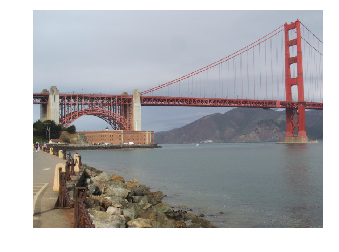

In [35]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    image = mpimg.imread(img_path)
    plt.axis('Off')
    plt.imshow(image)
     
    index_str = "Is this picture of the\n" + "{}, {}, or {}?".format(
                 predicted_landmarks[0], predicted_landmarks[1], predicted_landmarks[2])    
    
    print(index_str)
    
# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
- The output result is as I expected, not good, but not bad! I got test accuracy: 72% (908/1250) from previous step, so it supposes to have some false positive outcomes. And the test results aligned. I would consider try following ways for the improvement:

  - Try different pre-trained model architecture for approach, like VGG-19 or Inception-V3.

  - Add more data for training. This can be achieved by Google search landmark photos or perform rich augmentation technique.

  - Fine-tunning the model optimizer


In [23]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

In [36]:
!pwd

/home/workspace/nd101-c2-landmarks-starter/landmark_project


In [37]:
!ls

Google-Eiffel-Tower.JPG      Google-Sydney-Opera.jpg  model_transfer.pt
Google-Great-Wall-China.jpg  images		      model_vgg19.pt
Google-Gullfoss-Falls.jpg    landmark.ipynb
Google-Machu-Picchu.jpg      model_scratch.pt


Is this picture of the
Eiffel_Tower, Petronas_Towers, or Great_Wall_of_China?


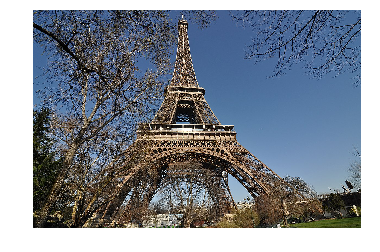

In [39]:
# 2nd submission, Test 1
image_1 = './Google-Eiffel-Tower.JPG'
suggest_locations(image_1)

Is this picture of the
Great_Wall_of_China, Machu_Picchu, or Edinburgh_Castle?


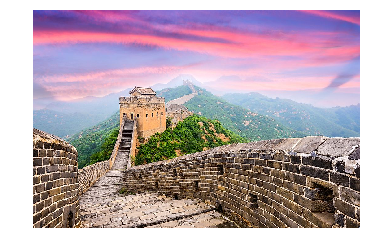

In [41]:
# 2nd submission, Test 2
image_2 = './Google-Great-Wall-China.jpg'
suggest_locations(image_2)

Is this picture of the
Yellowstone_National_Park, Niagara_Falls, or Banff_National_Park?


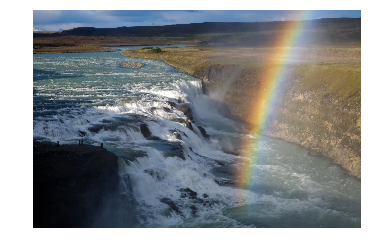

In [42]:
# 2nd submission, Test 3
image_3 = './Google-Gullfoss-Falls.jpg'
suggest_locations(image_3)

Is this picture of the
Banff_National_Park, Grand_Canyon, or Yellowstone_National_Park?


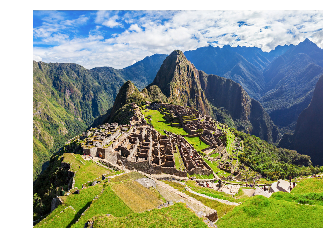

In [43]:
# 2nd submission, Test 4
image_4 = './Google-Machu-Picchu.jpg'
suggest_locations(image_4)

Is this picture of the
Sydney_Opera_House, Sydney_Harbour_Bridge, or Great_Barrier_Reef?


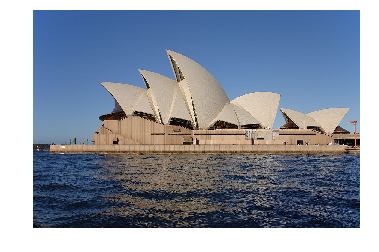

In [44]:
# 2nd submission, Test 5
image_5 = './Google-Sydney-Opera.jpg'
suggest_locations(image_5)

## ========== Below section is the 1st test submission ========== 

In [40]:
def cross_check(img_path):
    
    actual_label = int(img_path.split('/')[4].split('.')[0])
    
    print("Actual Class: {}".format(classes[actual_label]) + "\n" + "=====================================================")

Actual Class: 27.Seattle_Japanese_Garden
Is this picture of the
Central_Park, Seattle_Japanese_Garden, or Ljubljana_Castle?


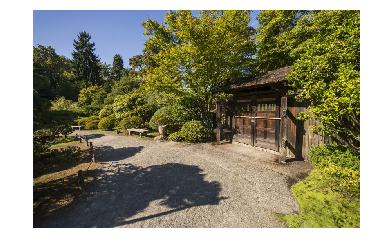

In [25]:
# Test 1
test1_img_path = '/data/landmark_images/train/27.Seattle_Japanese_Garden/08e937d076327d86.jpg'
cross_check(test1_img_path)
suggest_locations(test1_img_path)

Actual Class: 35.Monumento_a_la_Revolucion
Is this picture of the
Monumento_a_la_Revolucion, Temple_of_Heaven, or Terminal_Tower?


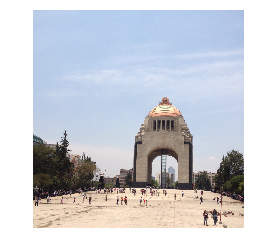

In [26]:
# Test 2
test2_img_path = '/data/landmark_images/train/35.Monumento_a_la_Revolucion/4c8a631db362fcd4.jpg'
cross_check(test2_img_path)
suggest_locations(test2_img_path)

Actual Class: 46.Great_Wall_of_China
Is this picture of the
Edinburgh_Castle, Great_Wall_of_China, or Ljubljana_Castle?


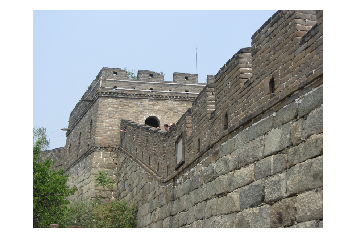

In [27]:
# Test 3
test3_img_path = '/data/landmark_images/train/46.Great_Wall_of_China/4f1bc4e1b24980a5.jpg'
cross_check(test3_img_path)
suggest_locations(test3_img_path)

Actual Class: 13.Yellowstone_National_Park
Is this picture of the
Yellowstone_National_Park, Banff_National_Park, or Gullfoss_Falls?


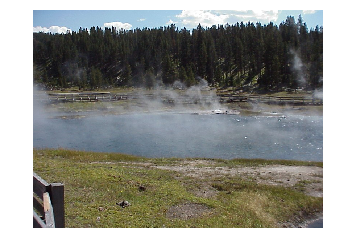

In [28]:
# Test 4
test4_img_path = '/data/landmark_images/train/13.Yellowstone_National_Park/4b045ecddc22ed32.jpg'
cross_check(test4_img_path)
suggest_locations(test4_img_path)

In [29]:
# Putting all together
def test_img_path_generator():
    
    base_dir = '/data/landmark_images/test/'
    test_dir = os.listdir(base_dir)
    picked_dir = np.random.choice(test_dir)
    picked_dir_path = base_dir + picked_dir
    picked_img = np.random.choice(os.listdir(picked_dir_path))
    picked_img_path = picked_dir_path + "/" + picked_img
    
    return picked_img_path

def update_suggest_locations(img_path):
    
    img_path = test_img_path_generator()
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    image = mpimg.imread(img_path)
    plt.axis('Off')
    plt.imshow(image)
    
    print("Actual Label: {}".format(img_path.split('/')[-2]) + "\n" + "=====================================================")
     
    index_str = "Is this picture of the\n" + "{}, {}, or {}?".format(
                 predicted_landmarks[0], predicted_landmarks[1], predicted_landmarks[2])    
    
    print(index_str)

Actual Label: 38.Forth_Bridge
Is this picture of the
Forth_Bridge, Sydney_Harbour_Bridge, or Golden_Gate_Bridge?


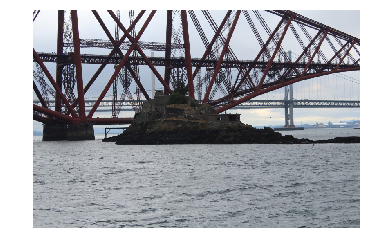

In [90]:
update_suggest_locations(test_img_path_generator())

Actual Label: 43.Gullfoss_Falls
Is this picture of the
Gullfoss_Falls, Yellowstone_National_Park, or Banff_National_Park?


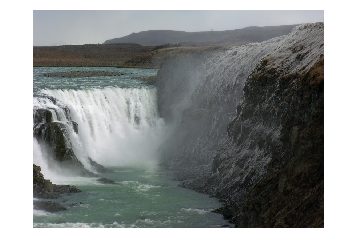

In [91]:
update_suggest_locations(test_img_path_generator())

Actual Label: 29.Petronas_Towers
Is this picture of the
Petronas_Towers, Terminal_Tower, or Sydney_Harbour_Bridge?


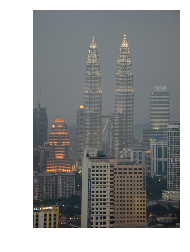

In [92]:
update_suggest_locations(test_img_path_generator())

Actual Label: 33.Sydney_Opera_House
Is this picture of the
Sydney_Harbour_Bridge, Brooklyn_Bridge, or Sydney_Opera_House?


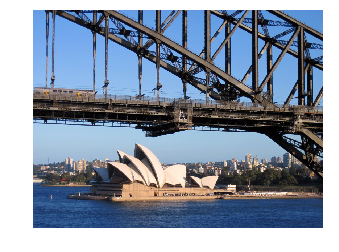

In [95]:
update_suggest_locations(test_img_path_generator())

Actual Label: 04.Wroclaws_Dwarves
Is this picture of the
Ljubljana_Castle, Central_Park, or Monumento_a_la_Revolucion?


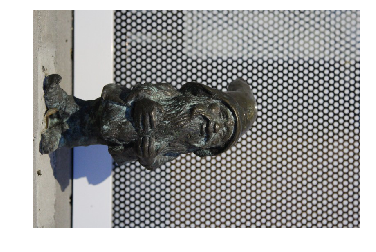

In [96]:
update_suggest_locations(test_img_path_generator())

Actual Label: 46.Great_Wall_of_China
Is this picture of the
Yellowstone_National_Park, Niagara_Falls, or Central_Park?


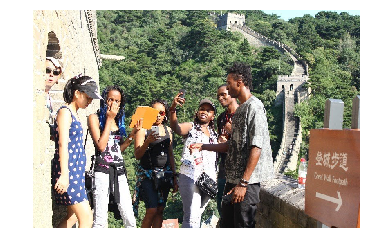

In [97]:
update_suggest_locations(test_img_path_generator())